# Reinforcement learning summer school at the VU - 2022 - Solutions

## Workshop tutorial, day 2: 

## Deep Reinforcement Learning Agent (Part 1)

### Author: Buelent Uendes

Before we dive into deep reinforcement learning, it is a good idea to familiarize ourselves with the gym environment provided by OpenAI and start with the simple Q learning agent. In the second notebook (Deep Reinforcement Learning Agent (Part 2), we will show how we implement a deep reinforcement learning algorithm to solve the environment.

**Instructions:**

In the notebook, you will see a couple of ToDos with some instructions. Try your best to work through them and to complete the notebook. In case you run into problems, do not hesitate to ask any of the TAs for help! :) 

## Import libraries 

In [11]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random

#Set the seed for reproducibility
np.random.seed(7)
random.seed(7)

## Open AI gym and the mountain car problem 

In the following, we will train our reinforcement learning algorithms on classical control problems provided by OpenAI gym. In particular, we will focus on the so-called mountain car problem. In this problem, the agent needs to learn how to drive a car up the right hill, given the constraint that the engine of the car is not strong enough to do so right away. Starting from the bottom of the hill, the agent therefore needs to go back and forth, thereby creating enough momentum, to drive up the mountain. Compared to other classical control problems, this is a quite challenging environment, as the agent never receives a non-negative reward unless the agent reaches the right hill. Thus, most of the time the agent receives a negative reward of -1 which makes learning difficult.

You can find more information about the mountain car environment [here](https://www.gymlibrary.ml/environments/classic_control/mountain_car/).

## Quick recap of working with the gym environment 

## 1) Creating the environment 


Creating an environment, is fairly easy:

In [12]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

#Set the seed
env.action_space.seed(42)

[42]

## 2) Getting familiar with some of the properties of the problem 

Before starting to work on the problem, it is important to familiarize oneself with the problem at hand, i.e. investigating the observation space and the action space. 

In [13]:
print('The observation space is ', env.observation_space)
print('The action space is ', env.action_space)

The observation space is  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is  Discrete(3)


As we can see, the observation space is continous with discrete number of actions. The agent can choose from three different actions:

- 0: Accelerate to the left
- 1: Do not accelerate
- 2: Accelerate to the right

One way to deal with continous action space is to discretize the state space into bins. This simplifies the problem and is a prerequisite for any tabular approach such as the Q learning.
    

To get a better idea of the observation space, we can check the range of the observation space.

In [14]:
low = env.observation_space.low
high =env.observation_space.high

In [15]:
low, high

(array([-1.2 , -0.07], dtype=float32), array([0.6 , 0.07], dtype=float32))

The first value of the observation space represents the x position, whereas the second one represents the velocity of the car. As we can see, the x position is in the range between $[-1.2, 0.6]$, whereas velocity lies in the range between $[-0.07, 0.07]$.

To create a new starting position, one can use the reset command as seen below:

In [16]:
env.reset()

(array([-0.578639,  0.      ], dtype=float32), {})

We an sample a random action from the environment via the following command:

In [17]:
env.step(env.action_space.sample())

e:\Users\Linuxer\miniconda3\envs\rl_env\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([-0.57922804, -0.00058907], dtype=float32), -1.0, False, False, {})

## First step: Random agent

It is always a good idea to test out the environment and start to play around. For this purpose, one can create an agent that plays the game with random actions.

In [18]:
env = gym.make(env_name)
env.reset()
for _ in range(500):
    if _ % 100 == 0:
        print(_)
    action = env.step(env.action_space.sample())
    env.render()

# This will stop the environment after
env.close()

0
100
200
300
400


e:\Users\Linuxer\miniconda3\envs\rl_env\Lib\site-packages\gym\envs\classic_control\mountain_car.py:171: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


## In conclusion:

As a recap, the main four functions for the environment space are:
- **env.reset():** 
    Resets the environment and obtain initial starting observation
- **env.render():** 
    Visualize the environment. Important Pygame needs to be installed for this
- **env.step(action):** 
    Applies an action to it. It outputes next state, reward, done and info
- **env.close():** 
    Closes the pop-up frame of the visualized environment

## Main problem: Let's learn an agent that uses Q-learning!

As mentioned above, we will first use implement a classical approach of TD-learning, i.e. Q-learning. Q-learning is an off-policy, tabular approach to reinforcement learning. Hence, we need to discretize the state space before proceeding.

It is important to keep in mind that we do not want to discretize the state space too much, given the **GLIE theorem**. **GLIE theorem stands for 'Greedy in the Limit with Infinite Exploration', which means that the state action pairs Q(s,a) will converge to the optimal ones if all state-action pairs are explored infinitely many times and the policy converges to the greedy one**. For this reason, we want to have not too many states and we need to tune the epsilon rate in such a way that it converges to zero.

**ToDo:**

In the following QAgent class, there are specific code sections missing. Please complete these so you can finalize the QAgent. If you get stuck, do not hesitate to ask the TAs!

In particular, you will be asked to implement parts of the discretizing, initializing the Q matrix and the epsilon greedy policy. These missing parts are all highlighted by a TODO!

## Finalizing the Q learning agent 

In [19]:
class QAgent():
    
    def __init__(self, env_name, discount_rate = 0.95, bin_size = 20):
        
        '''
        Params:
        
        env_name = name of the specific environment that the agent wants to solve
        discount_rate = discount rate used for future rewards
        bin_size = number of bins used for discretizing the state space
        
        '''
        
        #create an environment
        self.env_name = env_name
        self.env = gym.make(env_name)
        
        #Set the discount rate
        self.discount_rate = discount_rate
        
        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        self.action_space = self.env.action_space.n
        
        #Set the bin size
        self.bin_size = bin_size
        
        #State incorporates the observation state
        #State[0] is x position
        #State[1] is velocity
    
        #Get the low and high values of the environment space
        self.low = self.env.observation_space.low
        self.high = self.env.observation_space.high
    
        #Create bins for both observation features, i.e. x-position and velocity
        
        self.bin_x = np.linspace(self.low[0], self.high[0], self.bin_size)
    
        '''
        ToDo:
        
        Please create the bins for the velocity feature in the same manner and call this variable self.bin_velocity!
        '''
        
        #WRITE YOUR CODE HERE!
        
        #Solution
        self.bin_velocity = np.linspace(self.low[1], self.high[1], self.bin_size)
        
        #Append the two bins
        self.bins = [self.bin_x, self.bin_velocity]
    
    def discretize_state(self, state):
        
        '''
        Params:
        state = state observation that needs to be discretized
        
        
        Returns:
        discretized state
        '''
        #Now we can make use of the function np.digitize and bin it
        self.state = state
        
        #Create an empty state
        digitized_state = []
    
        for i in range(len(self.bins)):
            digitized_state.append(np.digitize(self.state[i], self.bins[i])-1)
        
        #Returns the discretized state from an observation
        return digitized_state
    
    def create_Q_table(self):
        self.state_space = self.bin_size - 1
        #Initialize all values in the Q-table to zero
        
        '''
        ToDo:
        Initialize a zero matrix of dimension state_space * state_space * action_space and call it self.Qtable!
        '''
        
        #Solution:
        self.Qtable = np.zeros((self.state_space, self.state_space, self.action_space))
        

    def train(self, simulations, learning_rate, epsilon = 0.05, epsilon_decay = 1000, adaptive_epsilon = False, 
              adapting_learning_rate = False):
        
        '''
        Params:
        
        simulations = number of episodes of a game to run
        learning_rate = learning rate for the update equation
        epsilon = epsilon value for epsilon-greedy algorithm
        epsilon_decay = number of full episodes (games) over which the epsilon value will decay to its final value
        adaptive_epsilon = boolean that indicates if the epsilon rate will decay over time or not
        adapting_learning_rate = boolean that indicates if the learning rate should be adaptive or not
        
        '''
        
        #Initialize variables that keep track of the rewards
        
        self.rewards = []
        self.average_rewards = []
        
        #Call the Q table function to create an initialized Q table
        self.create_Q_table()
        
        #Set epsilon rate, epsilon decay and learning rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        #Set start epsilon, so here we want a starting exploration rate of 1
        self.epsilon_start = 1
        self.epsilon_end = 0.05
        
        #If we choose adaptive learning rate, we start with a value of 1 and decay it over time!
        if adapting_learning_rate:
            self.learning_rate = 1
        
        for i in range(simulations):
            
            if i % 5000 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            #Initialize the state
            state = self.env.reset()
        
            #Set a variable that flags if an episode has terminated
            done = False
        
            #Discretize the state space
            
            state = self.discretize_state(state)
            
            break
            
            #Set the rewards to 0
            total_rewards = 0
            
            #If adaptive epsilon rate
            if adaptive_epsilon:
                self.epsilon = np.interp(i, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
                
                #Logging just to check it decays as we want it to do, we just print out the first three statements
                if i % 500 == 0 and i <= 1500:
                    print(f"The current epsilon rate is {self.epsilon}")
                
            #Loop until an episode has terminated
            while not done:
                
                #Pick an action based on epsilon greedy
                
                '''
                ToDo: Write the if statement that picks a random action
                Tip: Make use of np.random.uniform() and the self.epsilon to make a decision!
                Tip: You can also make use of the method sample() of the self.env.action_space 
                    to generate a random action!
                '''
                
                #Solution:
                
                #Pick random action
                if np.random.uniform(0,1) > 1-self.epsilon:
                    #This picks a random action from 0,1,2
                    action = self.env.action_space.sample()
                    
                    
                #Pick a greedy action
                else:
                    action = np.argmax(self.Qtable[state[0],state[1],:])
                    
                #Now sample the next_state, reward, done and info from the environment
                
                next_state, reward, done, info = self.env.step(action)
                
                #Now discretize the next_state
                next_state = self.discretize_state(next_state)
                
                #Target value 
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], next_state[1]]))
                
                #Calculate the Temporal difference error (delta)
                delta = self.learning_rate * (Q_target - self.Qtable[state[0], state[1], action])
                
                #Update the Q-value
                self.Qtable[state[0], state[1], action] = self.Qtable[state[0], state[1], action] + delta
                
                #Update the reward and the hyperparameters
                total_rewards += reward
                state = next_state
                
            
            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i+1)
            
            self.rewards.append(total_rewards)
            
            #Calculate the average score over 100 episodes
            if i % 100 == 0:
                self.average_rewards.append(np.mean(self.rewards))
                
                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []
        
        print('The simulation is done!')
        
    def visualize_rewards(self):
        plt.figure(figsize =(7.5,7.5))
        plt.plot(100*(np.arange(len(self.average_rewards))+1), self.average_rewards)
        plt.axhline(y = -110, color = 'r', linestyle = '-')
        plt.title('Average reward over the past 100 simulations', fontsize = 10)
        plt.legend(['Q-learning performance','Benchmark'])
        plt.xlabel('Number of simulations', fontsize = 10)
        plt.ylabel('Average reward', fontsize = 10)
            
    def play_game(self):
        #Get the optimized strategy:
        done = False
        #Start the game
        state = self.env.reset()
        while not done:
            state = self.discretize_state(state)
            #Pick the best acction from the saved Qtable
            action = np.argmax(self.Qtable[state[0],state[1],:])
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            self.env.render()
            #Pause to make it easier to watch
            time.sleep(0.05)
        #Close the pop-up window
        self.env.close()

## Let's run this and train the QAgent!

In [21]:
#State the name of the game
env_name = 'MountainCar-v0'

#You can change the learning rate and the number of simulations if you want (yet, it will take then of course longer)!
simulations = 15000
learning_rate = 0.10

'''
ToDo:
Initialize the Qagent and call the instance Qagent!
Afterwards,let it train over the number of simulations with the specific learning rate!
'''

#WRITE YOUR CODE HERE!
#With standard epsilon_greedy
Qagent_standard_greedy = QAgent(env_name)
Qagent_standard_greedy.train(simulations, learning_rate)

Please wait, the algorithm is learning! The current simulation is 0


TypeError: '<' not supported between instances of 'dict' and 'dict'

In [ ]:
#We can also train the Qagent with a decaying epsilon schedule

Qagent_epsilon_decay = QAgent(env_name)
Qagent_epsilon_decay.train(simulations, learning_rate, adaptive_epsilon=True)

Please wait, the algorithm is learning! The current simulation is 0
The current epsilon rate is 1.0
The current epsilon rate is 0.525
The current epsilon rate is 0.05
The current epsilon rate is 0.05
Please wait, the algorithm is learning! The current simulation is 5000
Please wait, the algorithm is learning! The current simulation is 10000
The simulation is done!


## Now we can plot the results 

First, we can plot the results for the Qagent that uses the standard epsilon greedy approach.

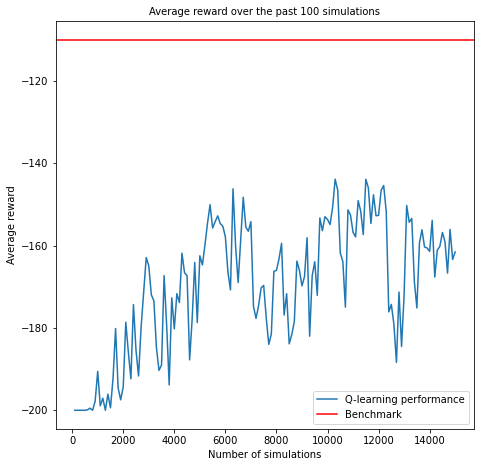

In [ ]:
Qagent_standard_greedy.visualize_rewards()

Next, we can see how the Qagent performs that uses an epsilon decaying schedule.

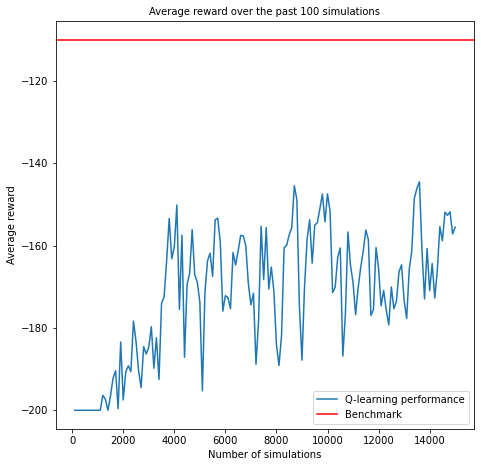

In [ ]:
Qagent_epsilon_decay.visualize_rewards()

Even though the TD algorithm improves over time, it fails to completely solve the environment, as it does not reach the benchmark of reaching an average reward of -110 ([check this link for further info](https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0)). Yet, we can check if the algorithm at least manages to the drive up the hill (see next section).

## Lastly, and finally we want to see if our QAgent learned the problem 

In [ ]:
Qagent_epsilon_decay.play_game()

**Done! Did your agent managed to climb up the hill? ;)**

## Further extensions 

The code above involves the standard tabular Q learning approach. Yet, one can extend this framework, by for example, 
make a warm start that, i.e. set the starting position different from the bottom of the hill, to help the agent explore the state space better. Yet, one can consider this as a form of cheating. 

Another possible extension is to do some form of reward shaping. Yet, this requires domain knowledge of the problem. For instance, in this case, we could change the reward function in a way that it also rewards velocity, as this is required for climbing up the hill. However, reward shaping is not a straightforward task, as one might introduce a wrong incentive for the agent which might counteract the initial goal!

**In the second notebook, we will see how we can extend the framework by approximating the Q function with a neural network, i.e. by introducing deep reinforcement learning!**
